In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Visualize Dataset

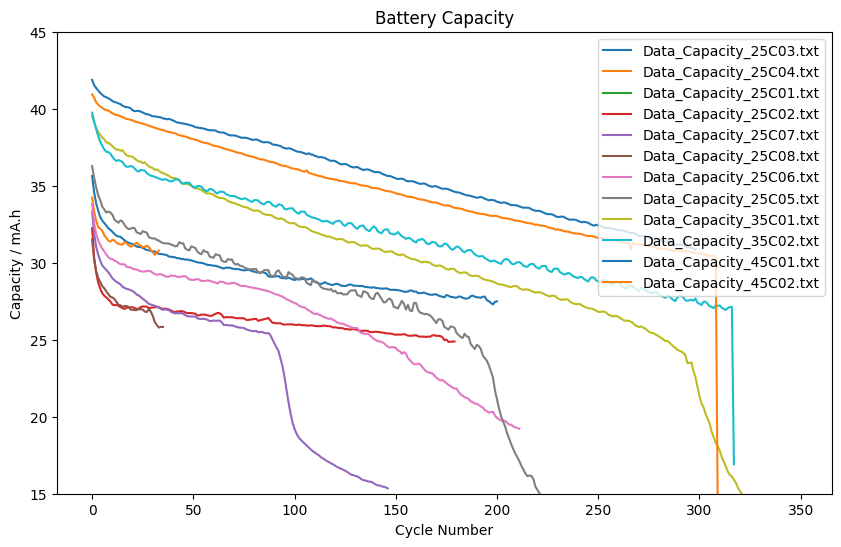

In [2]:
import matplotlib.pyplot as plt
import os
eis_dataset = os.listdir(path='/content/drive/MyDrive/EIS-data')
capacity_dataset = os.listdir('/content/drive/MyDrive/Capacity-data')

plt.figure(figsize=(10,6))
plt.ylim([15,45])
plt.title(label='Battery Capacity')
plt.xlabel('Cycle Number')
plt.ylabel('Capacity / mA.h')
for i in capacity_dataset:
    cap = pd.read_csv('/content/drive/MyDrive/Capacity-data/'+ i, delimiter='\t')
    cap = cap.loc[:, ~cap.columns.str.contains('^Unnamed')]
    Y_cap=[]
    n_cycles = cap.columns[1]
    n_cap = cap.columns[-1]
    for j in range(1,int(cap[n_cycles].max()+1)):
        capacity=[cap[cap[n_cycles]==j][n_cap].values[-1]]
        Y_cap.append(capacity)
    plt.plot(Y_cap,label=i[:])

plt.legend()

The aim of the project is to be able to predict this capacity degradation trend using the EIS dataset

Refining the EIS dataset and genarating the data required for training

In [66]:
def create_data(EIS_files,Capacity_files,Battery_Num):

    num_data_points = 61 #number of data points available for a given number of cycles of usage
    dataset = np.zeros(shape=(1, 2*num_data_points))

    features_path = '/content/drive/MyDrive/EIS-data/'+str(EIS_files)
    targets_path = '/content/drive/MyDrive/Capacity-data/'+str(Capacity_files)
    f = pd.read_csv(features_path, delimiter='\t')
    features_data = f.to_csv('/content/drive/MyDrive/a.csv', index=None)
    features_data = pd.read_csv('/content/drive/MyDrive/a.csv')

    t = pd.read_csv(targets_path, delimiter='\t')
    targets_data = t.to_csv('/content/drive/MyDrive/a.csv', index=None)
    targets_data = pd.read_csv('/content/drive/MyDrive/a.csv')
    targets_data = targets_data.loc[:, ~targets_data.columns.str.contains('^Unnamed')]

    n_cycles_f = features_data.columns[1]
    n_cap = targets_data.columns[-1]
    n_cycles_t = targets_data.columns[1]
    data=[]
    for i in range(int(features_data[n_cycles_f].min()),int(features_data[n_cycles_f].max())+1):
        try:
            features = features_data[features_data[n_cycles_f]==i] #collecting impedence data for cycle i
            features = features.iloc[:,3:5]
            re = features.iloc[:,0] #real and imaginary part of impedence
            im = features.iloc[:,1]

            capacity = [targets_data[targets_data[n_cycles_t]==i][n_cap].values[-1]] #Battery capacity at that particular cycle
            tot = np.concatenate([re,im,capacity,[Battery_Num]],axis=0)
        except:
          continue
        data.append(tot)
    data = np.array(data)
    dataset = np.concatenate([dataset,data],axis=0)
    dataset = pd.DataFrame(dataset)


    columns = []
    for i in range(1,num_data_points):
        columns.append('Real Z'+str(i))
    for i in range(1,num_data_points):
        columns.append('Imaginary Z'+str(i))
    columns.extend(['Capacity','Battery Number'])

    dataset.columns = columns
    return dataset.iloc[1:,:]


In [67]:
eis_3 = []
for i in eis_dataset:
    if i[10:14]=='III_':
        eis_3.append(i) #list of esi dataset files of set 3 (arbitrarily chosen)

t = []
for i in range(len(eis_3)):
  t.append(create_data(eis_3[i], capacity_dataset[i], i+1))

train = pd.concat(t, ignore_index=True)
train.head()

,Real Z1,Real Z2,Real Z3,Real Z4,Real Z5,Real Z6,Real Z7,Real Z8,Real Z9,Real Z10,...,Imaginary Z53,Imaginary Z54,Imaginary Z55,Imaginary Z56,Imaginary Z57,Imaginary Z58,Imaginary Z59,Imaginary Z60,Capacity,Battery Number
0,0.26768,0.27533,0.28455,0.29295,0.30268,0.31405,0.32656,0.34025,0.35337,0.36902,...,0.20657,0.16460,0.11098,0.04966,0.04945,0.17528,0.45059,0.83157,35.637472,1.0
1,0.27013,0.27901,0.28848,0.29635,0.30538,0.31721,0.32959,0.34412,0.35749,0.37307,...,0.07808,0.07275,0.11630,0.24117,0.43858,0.63840,0.74841,0.68496,34.564877,1.0
2,0.27166,0.28023,0.28756,0.29802,0.30822,0.32000,0.33105,0.34570,0.35878,0.37520,...,0.07616,0.08331,0.13923,0.27860,0.47285,0.64977,0.71723,0.60740,33.850376,1.0
3,0.27274,0.28146,0.29037,0.29876,0.30822,0.32023,0.33338,0.34680,0.36123,0.37620,...,0.23517,0.20511,0.15204,0.07570,0.03783,0.10753,0.34231,0.73016,33.378324,1.0
4,0.27373,0.28092,0.28794,0.29922,0.31022,0.31956,0.33294,0.34724,0.36020,0.37581,...,0.26725,0.30066,0.29739,0.22415,0.11153,0.01324,0.01901,0.22205,32.967148,1.0


In [68]:
diff = np.diff(t[6]['Capacity'],n=1)
limit = np.argmin(diff[20:])+20
t[6].drop(index=range(limit,t[6].shape[0]+1),inplace=True)
diff = np.diff(t[4]['Capacity'],n=1)
limit = np.argmin(diff[20:])+20
t[4].drop(index=range(limit,t[4].shape[0]+1),inplace=True)

#Dividing the training data into train and test
x_train = train.iloc[:,:120]
y_train = train['Capacity'].values.reshape(-1,1)
groups = train['Battery Number'].values.astype(int)

t4_features = t[4].iloc[:,0:120]
t4_capacity = t[4]['Capacity'].values
t5_features = t[5].iloc[:,0:120]
t5_capacity = t[5]['Capacity'].values
t6_features = t[6].iloc[:,0:120]
t6_capacity = t[6]['Capacity'].values
t7_features = t[7].iloc[:,0:120]
t7_capacity = t[7]['Capacity'].values

test = pd.concat([t[4],t[5],t[6],t[7]],axis=0,ignore_index=True)
train_new = pd.concat([t[1],t[2],t[3]],axis=0,ignore_index=True)
x_new_train = train_new.iloc[:,0:120]
y_new_train = train_new['Capacity'].values
x_test = test.iloc[:,0:120]
y_test = test['Capacity'].values

Gaussian Process Regression

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import r2_score,mean_squared_error

In [70]:
gp = GaussianProcessRegressor(alpha=100,kernel=5*RBF(),n_restarts_optimizer=5)
gp.fit(x_train,y_train)
GaussianProcessRegressor(alpha=100, kernel=2.24**2 * RBF(length_scale=1),
                         n_restarts_optimizer=5)
y_pred = gp.predict(x_test)
pd.DataFrame([y_test,y_pred])

,0,1,2,3,4,5,6,7,8,9,...,428,429,430,431,432,433,434,435,436,437
0,33.305422,31.870997,31.042692,30.518888,30.134553,29.824432,29.676846,29.522649,29.383856,29.199257,...,10.446778,10.239374,10.036516,9.976598,9.802148,9.615832,9.384035,9.206988,9.050319,8.881946
1,21.754888,26.115154,27.485525,27.206711,26.495945,27.599493,28.461644,27.047770,27.541779,27.815567,...,10.313106,10.461757,10.085993,9.434390,10.335071,10.021772,10.747271,9.526466,9.244536,9.800410


In [71]:
testing_cells=[x_train,t4_features,t5_features,t6_features,t7_features]
testing_caps=[y_train,t4_capacity,t5_capacity,t6_capacity,t7_capacity]
r2Score = []
error = []
predictions = []

for i,j in zip(testing_cells,testing_caps):
    y_pred = gp.predict(i)
    r2Score.append(r2_score(j, y_pred))
    error.append(np.sqrt(mean_squared_error(j, y_pred)))
    predictions.append(y_pred)

Visualize the test data

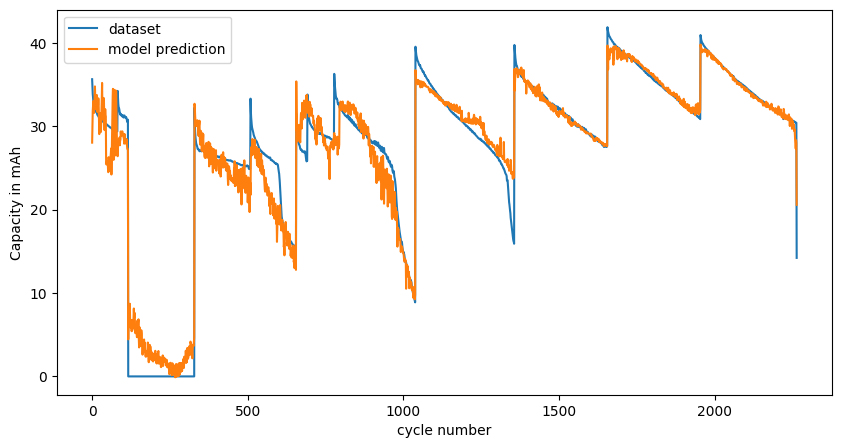

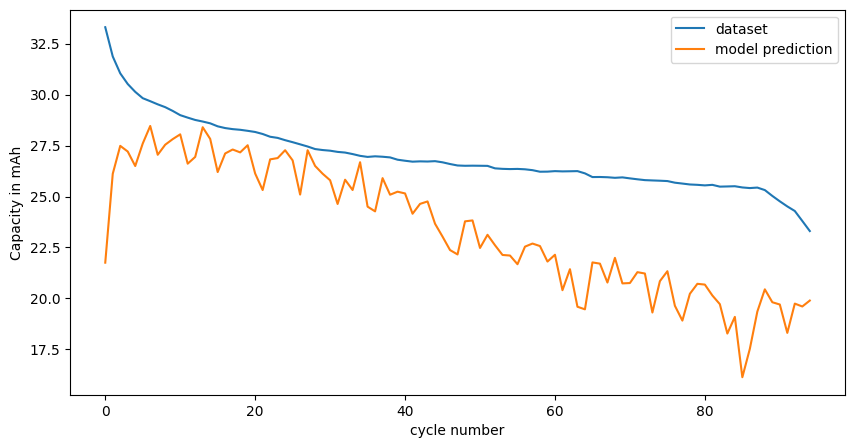

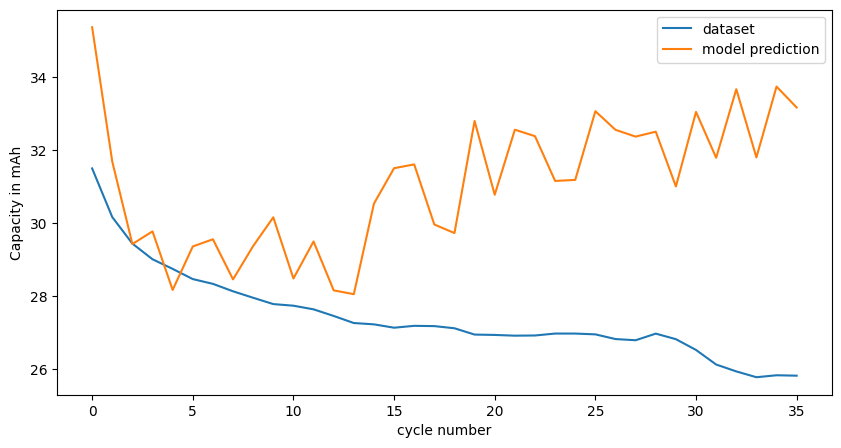

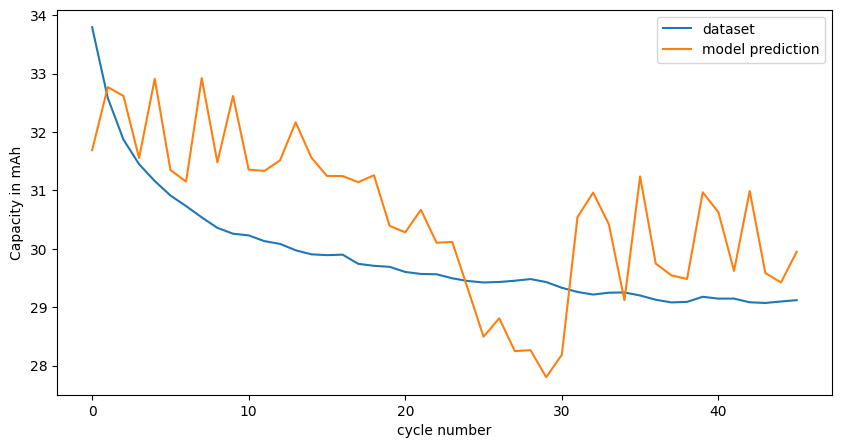

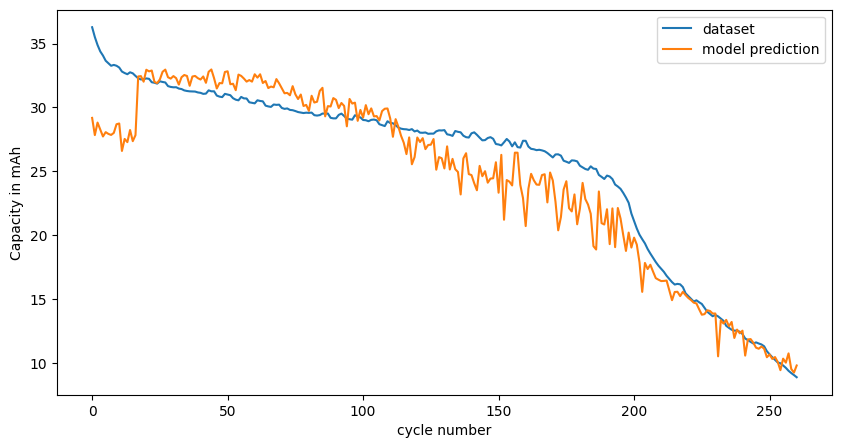

In [76]:
for i,j in zip(testing_caps, predictions):
  plt.figure(figsize=(10,5))
  plt.plot(i, label='dataset')
  plt.plot(j, label='model prediction')
  plt.xlabel('cycle number')
  plt.ylabel('Capacity in mAh')
  plt.legend()

Let's see the r2 score and error of the model prediction \
r2 score = The proportion of the variation in the dependent variable that is predictable from the independent variable \
error = Square root of mse

[0.9590022365211094, -5.229011416864531, -12.277418959136972, -0.6958653542282724, 0.8743435898057789]


<BarContainer object of 5 artists>

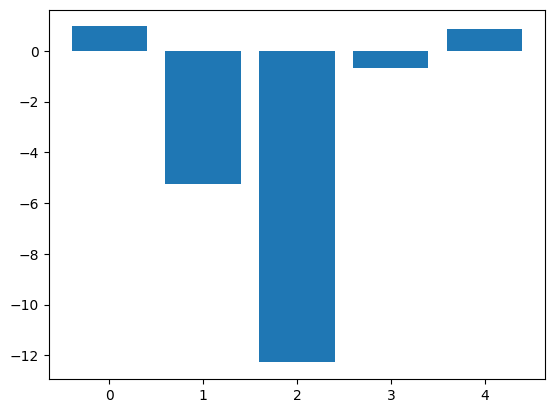

In [81]:
print(r2Score)
plt.bar(np.arange(len(r2Score)), r2Score)

We observe that we have excellent r2 scores for case 0 and case 4 as is evident from the plot also. In other cases the r2 score is negative which means that model performs worse than constant mean value prediction

[2.0897630200453876, 4.147562555900065, 4.34558642896549, 1.2651138152039259, 2.4493537209371476]


<BarContainer object of 5 artists>

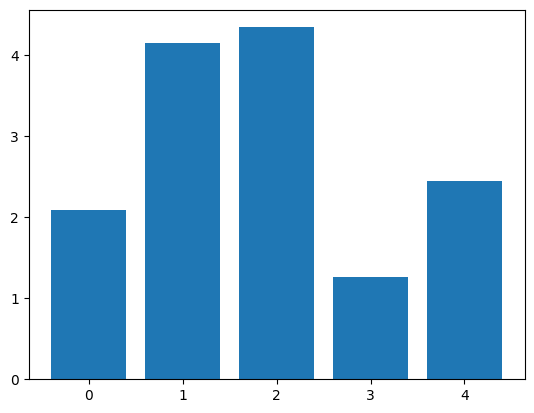

In [82]:
print(error)
plt.bar(np.arange(len(error)), error)

The mean error is pretty decent